# **Group Report**

# TODO
- Decide with backward or forward selection
- report accuracy metric using worksheet 13 material
- Remove ggpairs plot in EDA as it is too large and provides little explanation: Be sure to not print output that takes up a lot of screen space.
- Rewording and rewrite
- Update discussion

Employee turnover is considered a major problem for many organizations and enterprises. The problem is critical because it affects not only the sustainability of work but also the continuity of enterprise planning and culture. 


In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(infer)
library(broom)
library(leaps)
library(cowplot)
library(GGally)
library(AER)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## **Intro**

### **Question**

Knowing the age distribution of a company's workforce helps employers plan the workplace culture and the hiring of new staff (Gao et al., 2018). Further, being able to predict an employee's age is a possible way to assess the overall performance of the company (Shore et al, 2003). As such, we aim to find how accuractely can age be predicted using a linear regression of the optimally selected features of an employee dataset. Then, we plan on quantifying its effectiveness and evaluating its adherence to our linear model assumptions.

Data sourced from https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset

### **Description**

This dataset contains personal data from 4653 employees from a company with locations across India. For each employee it contains the following information: Education, JoiningYear, City, PaymentTier, Age, Gender, EverBenched, ExperienceInCurrentDomain, LeaveOrNot. There are no missing values from any of these columns in the dataset. 

- `Education` is a categorical/ordinal variable with levels: Bachelors, Masters, PHD. A vase majority of employees only have a Bachelors while only a few of a PhD.
- `JoiningYear` is a quantitative variable with range from 2012 to 2018, having both a mean and median of 2015.
- `City` is a categorical variable with levels: Bangalore, Pune, and New Delhi. Around half of employees work in Bangalore while the other half are split between New Delhi and Pune. 
- `PaymentTier` is a categorical and possibly ordinal variable with levels: 1, 2, 3. 3 is by far the most abundant and 1 is the least.
- `Age` is a quantitative variable with range 22-41 with mean 29.39 and median 28.
- `Gender` is a qualitative variable with levels: Male and Female. There are 1875 Females and 2778 Males.
- `Everbenched` is a binary qualitative variable with levels: yes and no. Only 478 of 4653 have ever been benched.
- `ExperienceInCurrentDomain` is a quantitative variable with a range from 0-7 years. The mean and median are both close to 3.
- `LeaveOrNot` is a binary qualitative variable with levels 0 or 1. 1600 or around a third are 1, the rest are 0.


<br>

## **EDA**

### **Loading data**

In [2]:
employee_data <- read_csv("Employee.csv", show_col_types = FALSE)
head(employee_data, 1)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0,0


In [3]:
nrow(employee_data)

[1] 4653

In [5]:
sum(is.na(employee_data))

[1] 0

### **Reshaping data**

First, we must make our categorical variables factors, then we can rerun our summary to see the new results and value counts. Setting these variables as factor variables is important for analysis and to ensure they are properly interpreted by the model we create.

In [6]:
employee_data$Education   = factor(employee_data$Education)
employee_data$City        = factor(employee_data$City)
employee_data$PaymentTier = factor(employee_data$PaymentTier)
employee_data$Education   = factor(employee_data$Education)
employee_data$Gender      = factor(employee_data$Gender)
employee_data$EverBenched = factor(employee_data$EverBenched)
employee_data$LeaveOrNot  = factor(employee_data$LeaveOrNot)

Age, JoiningYear, and ExperienceInCurrentDomain seem as though they would be correlated given they are all time based metrics. This assumption is checked below.

In [8]:
cor(employee_data$Age,employee_data$ExperienceInCurrentDomain)

[1] -0.1346429

In [9]:
cor(employee_data$Age,employee_data$JoiningYear)

[1] 0.01316529

This histogram shows the distribution of age for all employees and serves as a reference for comparison for grouped histograms done further below.

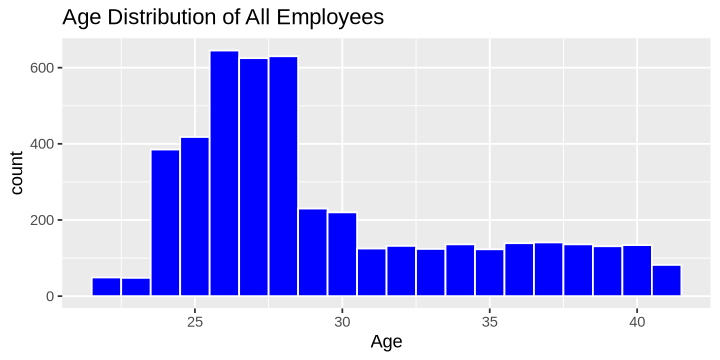

In [11]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(employee_data, aes(x = Age)) + geom_histogram(bins = 20, color = "white", fill = "blue") + xlab("Age") + ggtitle("Age Distribution of All Employees")

The set of visualizations below is to explore how different features influence the distribution of the target column, Age. The features being analyzed overlap significantly with the ones identified by the forward selection.

`summarise()` has grouped output by 'Age'. You can override using the `.groups`
argument.


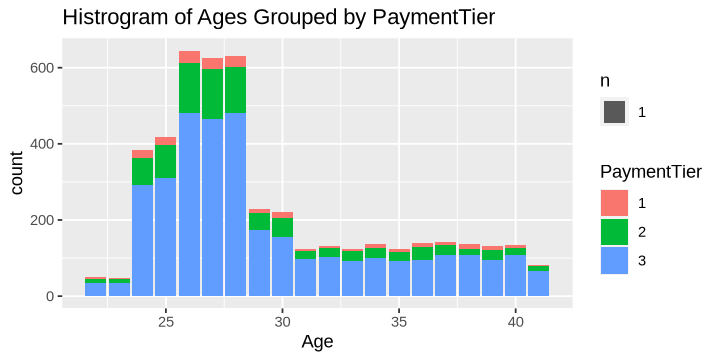

In [12]:
employee_data %>% group_by(Age, PaymentTier) %>% summarise(count=n()) %>% ggplot(aes(x=Age,y=count,fill=PaymentTier)) + geom_bar(stat="sum")+ ggtitle("Histrogram of Ages Grouped by PaymentTier")

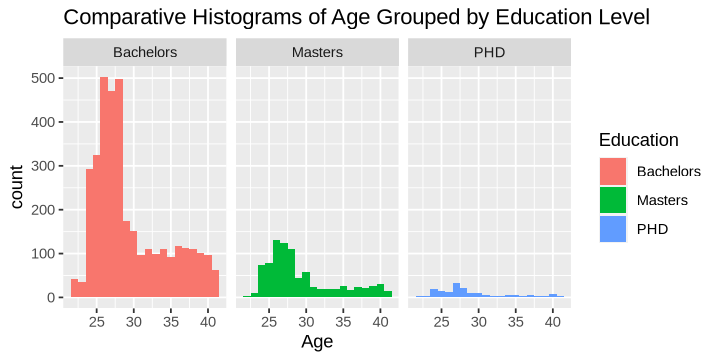

In [13]:
ggplot(employee_data, aes(Age, fill=Education)) + geom_histogram(bins=20) + facet_grid(.~Education) + ggtitle("Comparative Histograms of Age Grouped by Education Level")

The histograms are all fairly similar in shape with some slight differences. This plot also shows the proportion of employees at each level of education.

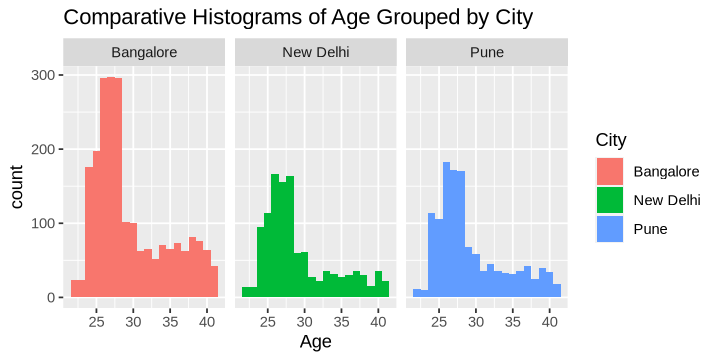

In [14]:
ggplot(employee_data,aes(Age, fill = City)) + geom_histogram(bins = 20) + facet_grid(.~City) + ggtitle("Comparative Histograms of Age Grouped by City")

This plot shows very similar age distributions between locations.

The features Age and LeaveOrNot make indistinguishably different histograms on their own so I chose to compare both features at once in the form of boxplots to better illustrate the data.

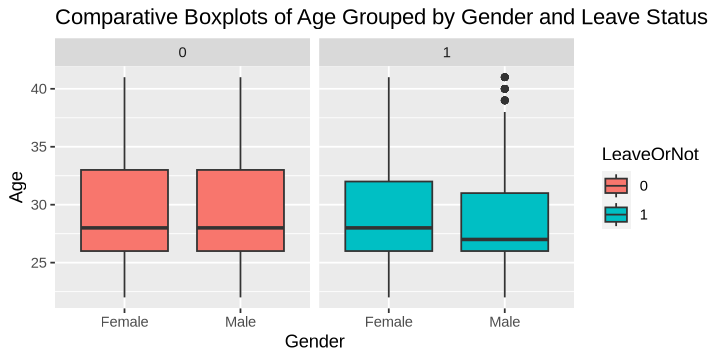

In [15]:
ggplot(employee_data, aes(x = Gender,y = Age,fill = LeaveOrNot)) + geom_boxplot() + labs(title = "CMP") + facet_wrap(~LeaveOrNot) + ggtitle("Comparative Boxplots of Age Grouped by Gender and Leave Status")

This plot shows that the median of men on leave tends to be slightly lower in age than the other demographics. Aside from this, all else is fairly similar.

The visualizations above helped show the impact of different features on age distribution but were not very insightful with minimal differences being illustrated. The following code is for my chosen visualization for analysis.

<br>

<br>

## **Method**

### **Splitting the data**

In [24]:
set.seed(123)
employee_split <- initial_split(employee_data, prop = 0.7, strata = PaymentTier)
employee_training <- training(employee_split)
employee_testing  <- testing(employee_split)

head(employee_training, 1)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
Masters,2017,New Delhi,2,37,Male,No,2,0


### **Forward Selection**

In [16]:
employee_forward_sel <- regsubsets(x = Age ~ ., nvmax = 11, data = employee_training, method = "forward",)

employee_forward_summary <- summary(employee_forward_sel)
employee_forward_summary

Subset selection object
Call: regsubsets.formula(x = Age ~ ., nvmax = 11, data = employee_training, 
    method = "forward", )
11 Variables  (and intercept)
                          Forced in Forced out
EducationMasters              FALSE      FALSE
EducationPHD                  FALSE      FALSE
JoiningYear                   FALSE      FALSE
CityNew Delhi                 FALSE      FALSE
CityPune                      FALSE      FALSE
PaymentTier2                  FALSE      FALSE
PaymentTier3                  FALSE      FALSE
GenderMale                    FALSE      FALSE
EverBenchedYes                FALSE      FALSE
ExperienceInCurrentDomain     FALSE      FALSE
LeaveOrNot1                   FALSE      FALSE
1 subsets of each size up to 11
Selection Algorithm: forward
          EducationMasters EducationPHD JoiningYear CityNew Delhi CityPune
1  ( 1 )  " "              " "          " "         " "           " "     
2  ( 1 )  " "              " "          " "         " "           " 

In [17]:
employee_forward_summary_df <- tibble(
    n_input_variables = 1:11,
    RSQ    = employee_forward_summary$rsq,
    RSS    = employee_forward_summary$rss,
    ADJ.R2 = employee_forward_summary$adjr2,
    Cp     = employee_forward_summary$cp,
    BIC    = employee_forward_summary$bic,
)
employee_forward_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01615063,72813.61,0.01584828,33.951837,-36.839238
2,0.02237312,72353.09,0.02177206,15.169387,-49.409396
3,0.02399970,72232.71,0.02309933,11.736809,-46.742975
4,0.02508542,72152.36,0.02388589,10.110620,-42.278769
5,0.02618181,72071.22,0.02468363,8.448792,-37.854278
6,0.02702556,72008.77,0.02522874,7.630756,-32.588359
7,0.02770352,71958.60,0.02560805,7.366444,-26.769645
8,0.02818102,71923.26,0.02578664,7.771641,-20.280826
9,0.02841680,71905.81,0.02572294,8.984171,-12.982619


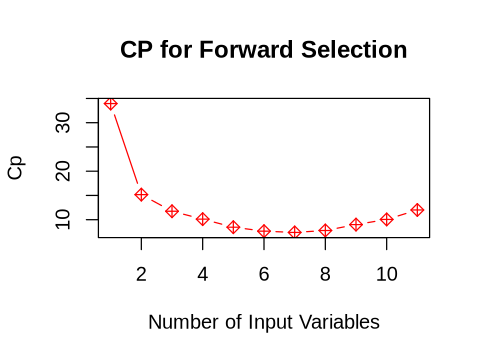

In [18]:
options(repr.plot.width = 4, repr.plot.height = 3)
plot(summary(employee_forward_sel)$cp, main = "CP for Forward Selection", xlab = "Number of Input Variables", ylab = "Cp", type = "b", pch = 9, col = "red")

In [19]:
cp_min_forward_sel = which.min(employee_forward_summary$cp) 

cp_min_forward_sel
selected_var_forward_sel <- names(coef(employee_forward_sel, cp_min_forward_sel))[-1]
selected_var_forward_sel

[1] 7

[1] "EducationMasters"          "JoiningYear"              
[3] "CityNew Delhi"             "CityPune"                 
[5] "GenderMale"                "ExperienceInCurrentDomain"
[7] "LeaveOrNot1"

<br>

### **Backward selection**

In [20]:
employee_backward_sel <- regsubsets(x = Age ~ ., nvmax = 11, data = employee_training, method = "backward",)

employee_backward_summary <- summary(employee_backward_sel)
employee_backward_summary

Subset selection object
Call: regsubsets.formula(x = Age ~ ., nvmax = 11, data = employee_training, 
    method = "backward", )
11 Variables  (and intercept)
                          Forced in Forced out
EducationMasters              FALSE      FALSE
EducationPHD                  FALSE      FALSE
JoiningYear                   FALSE      FALSE
CityNew Delhi                 FALSE      FALSE
CityPune                      FALSE      FALSE
PaymentTier2                  FALSE      FALSE
PaymentTier3                  FALSE      FALSE
GenderMale                    FALSE      FALSE
EverBenchedYes                FALSE      FALSE
ExperienceInCurrentDomain     FALSE      FALSE
LeaveOrNot1                   FALSE      FALSE
1 subsets of each size up to 11
Selection Algorithm: backward
          EducationMasters EducationPHD JoiningYear CityNew Delhi CityPune
1  ( 1 )  " "              " "          " "         " "           " "     
2  ( 1 )  " "              " "          " "         " "           

In [21]:
employee_backward_summary_df <- tibble(
    n_input_variables = 1:11,
    RSQ    = employee_forward_summary$rsq,
    RSS    = employee_forward_summary$rss,
    ADJ.R2 = employee_forward_summary$adjr2,
    Cp     = employee_forward_summary$cp,
    BIC    = employee_forward_summary$bic,
)
employee_backward_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01615063,72813.61,0.01584828,33.951837,-36.839238
2,0.02237312,72353.09,0.02177206,15.169387,-49.409396
3,0.02399970,72232.71,0.02309933,11.736809,-46.742975
4,0.02508542,72152.36,0.02388589,10.110620,-42.278769
5,0.02618181,72071.22,0.02468363,8.448792,-37.854278
6,0.02702556,72008.77,0.02522874,7.630756,-32.588359
7,0.02770352,71958.60,0.02560805,7.366444,-26.769645
8,0.02818102,71923.26,0.02578664,7.771641,-20.280826
9,0.02841680,71905.81,0.02572294,8.984171,-12.982619


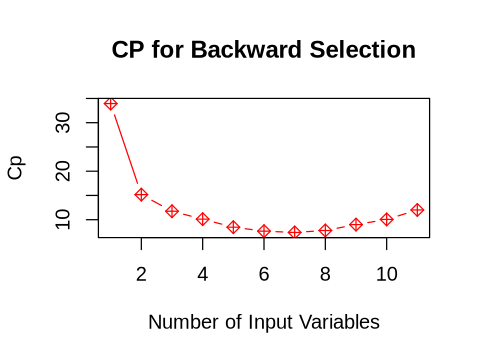

In [22]:
plot(summary(employee_backward_sel)$cp, main = "CP for Backward Selection", xlab = "Number of Input Variables", ylab = "Cp", type = "b", pch = 9, col = "red")

In [23]:
cp_min_backward_sel = which.min(employee_backward_summary$cp) 
selected_var_backward_sel <- names(coef(employee_backward_sel, cp_min_backward_sel))[-1]
selected_var_backward_sel

[1] "EducationMasters"          "JoiningYear"              
[3] "CityNew Delhi"             "CityPune"                 
[5] "GenderMale"                "ExperienceInCurrentDomain"
[7] "LeaveOrNot1"

<br>

<br>

## **Discussion**

This is my key visualization of the exploratory data analysis. This plot shows the Cp for each of the models trained in the forward selection conducted on the employee training dataset. I ran the forward selection because there were few variables that stood out as being particularly good predictors of age. I chose this visualization as the others were less definitive and explicit. The forward selection identified the features that would produce the best linear model for predicting age. The visualization shows that a minimum Cp is clearly achieved at 7 input variables indicating that this is the optimal amount for the linear model. The Cp at this level is 7.366, since the Cp is close to p=7 it indicates that there is minimal over-fitting and under-fitting. It also clearly illustrates that the inclusion of more variables doesn't necessarily make the model better. With the help of this analysis I was able to identify the 7 best variables and will be using them for my regression model.


**References**

Xiang Gao, Junhao Wen, Cheng Zhang, "An Improved Random Forest Algorithm for Predicting Employee Turnover", Mathematical Problems in Engineering, vol. 2019, Article ID 4140707, 12 pages, 2019. https://doi.org/10.1155/2019/4140707

Shore, L. M., Cleveland, J. N., & Goldberg, C. B. (2003). Work attitudes and decisions as a function of manager age and employee age. Journal of Applied Psychology, 88(3), 529–537. https://doi.org/10.1037/0021-9010.88.3.529